# Preamble

In [95]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
import os
import xgboost as xgb
#import cartopy.crs as ccrs
from sklearn import tree
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image, display
import time

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6
rcParams.update({'font.size': 18})
rcParams.update({'figure.autolayout': False})

colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#4f4f4f', '#bcbd22', '#17becf', 
           '#0f67a4', '#ef6f00', '#1c901c', '#c61718', '#8457ad', '#7c463b', '#d367b2', '#3f3f3f', '#acad12', '#07aebf', 
           '#2f87c4', '#ff8f1e', '#3cb03c', '#e63738', '#a477cd', '#9c665b', '#f387d2', '#5f5f5f', '#cccd32', '#27cedf']

# Pre-processing

## Load data

In [96]:
data = pd.read_csv('A2B_Training_Dataset.csv')

In [97]:
# load data and parse dates
data = pd.read_csv('A2B_Training_Dataset.csv')

data.drop(columns=['Unnamed: 0', 'BookingID'], inplace=True)

data['M_On_Time'] = pd.to_datetime(data['M_On_Time'])
data['M_Off_Time'] = pd.to_datetime(data['M_Off_Time'])

In [98]:
data.head()

,M_On_Time,Lat_M_On,Long_M_On,M_Off_Time,Lat_M_Off,Long_M_Off,City,Dest_Suburb,DelJobDistance,DelJobTime,ChargesPrice,ChargesExtra,ChargesFlagfall
0,2019-07-23 06:54:39,-30.353364,153.094583,2019-07-23 07:03:24,-30.322766,153.115583,Tamworth,Coffs Harbour Airport,6000,525,14.1,2.3,4.1
1,2019-09-04 16:35:27,-30.310815,153.105125,2019-09-04 16:42:51,-30.287417,153.117083,Tamworth,Coffs Harbour,4150,444,10.9,2.3,4.1
2,2019-10-04 09:55:13,-33.824073,151.172659,2019-10-04 09:55:36,-33.825171,151.174209,Sydney,Sydney,500,23,1.4,1.1,3.6
3,2019-08-29 20:04:59,-33.888697,151.208008,2019-08-29 20:21:39,-33.871832,151.252742,Sydney,Bellevue Hill,7850,1000,21.3,3.6,3.6
4,2019-09-19 02:56:22,-33.883459,151.159525,2019-09-19 03:06:43,-33.896778,151.152915,Sydney,Ashfield,2250,627,11.8,3.6,3.6


## Remove outliers
Outmost 1% from distance, time and charges price

In [99]:
inliers = data.loc[data['DelJobDistance'].between(data['DelJobDistance'].quantile(0.01), data['DelJobDistance'].quantile(0.99)) & \
                   data['DelJobTime'].between(data['DelJobTime'].quantile(0.01), data['DelJobTime'].quantile(0.99)) & \
                   data['ChargesPrice'].between(data['ChargesPrice'].quantile(0.01), data['ChargesPrice'].quantile(0.99))].index

data = data.loc[inliers]

## Separate cities

In [100]:
data['City'].where((data['City']=='Sydney') | (data['Long_M_On']<=152), 'Coffs Harbour', inplace=True)

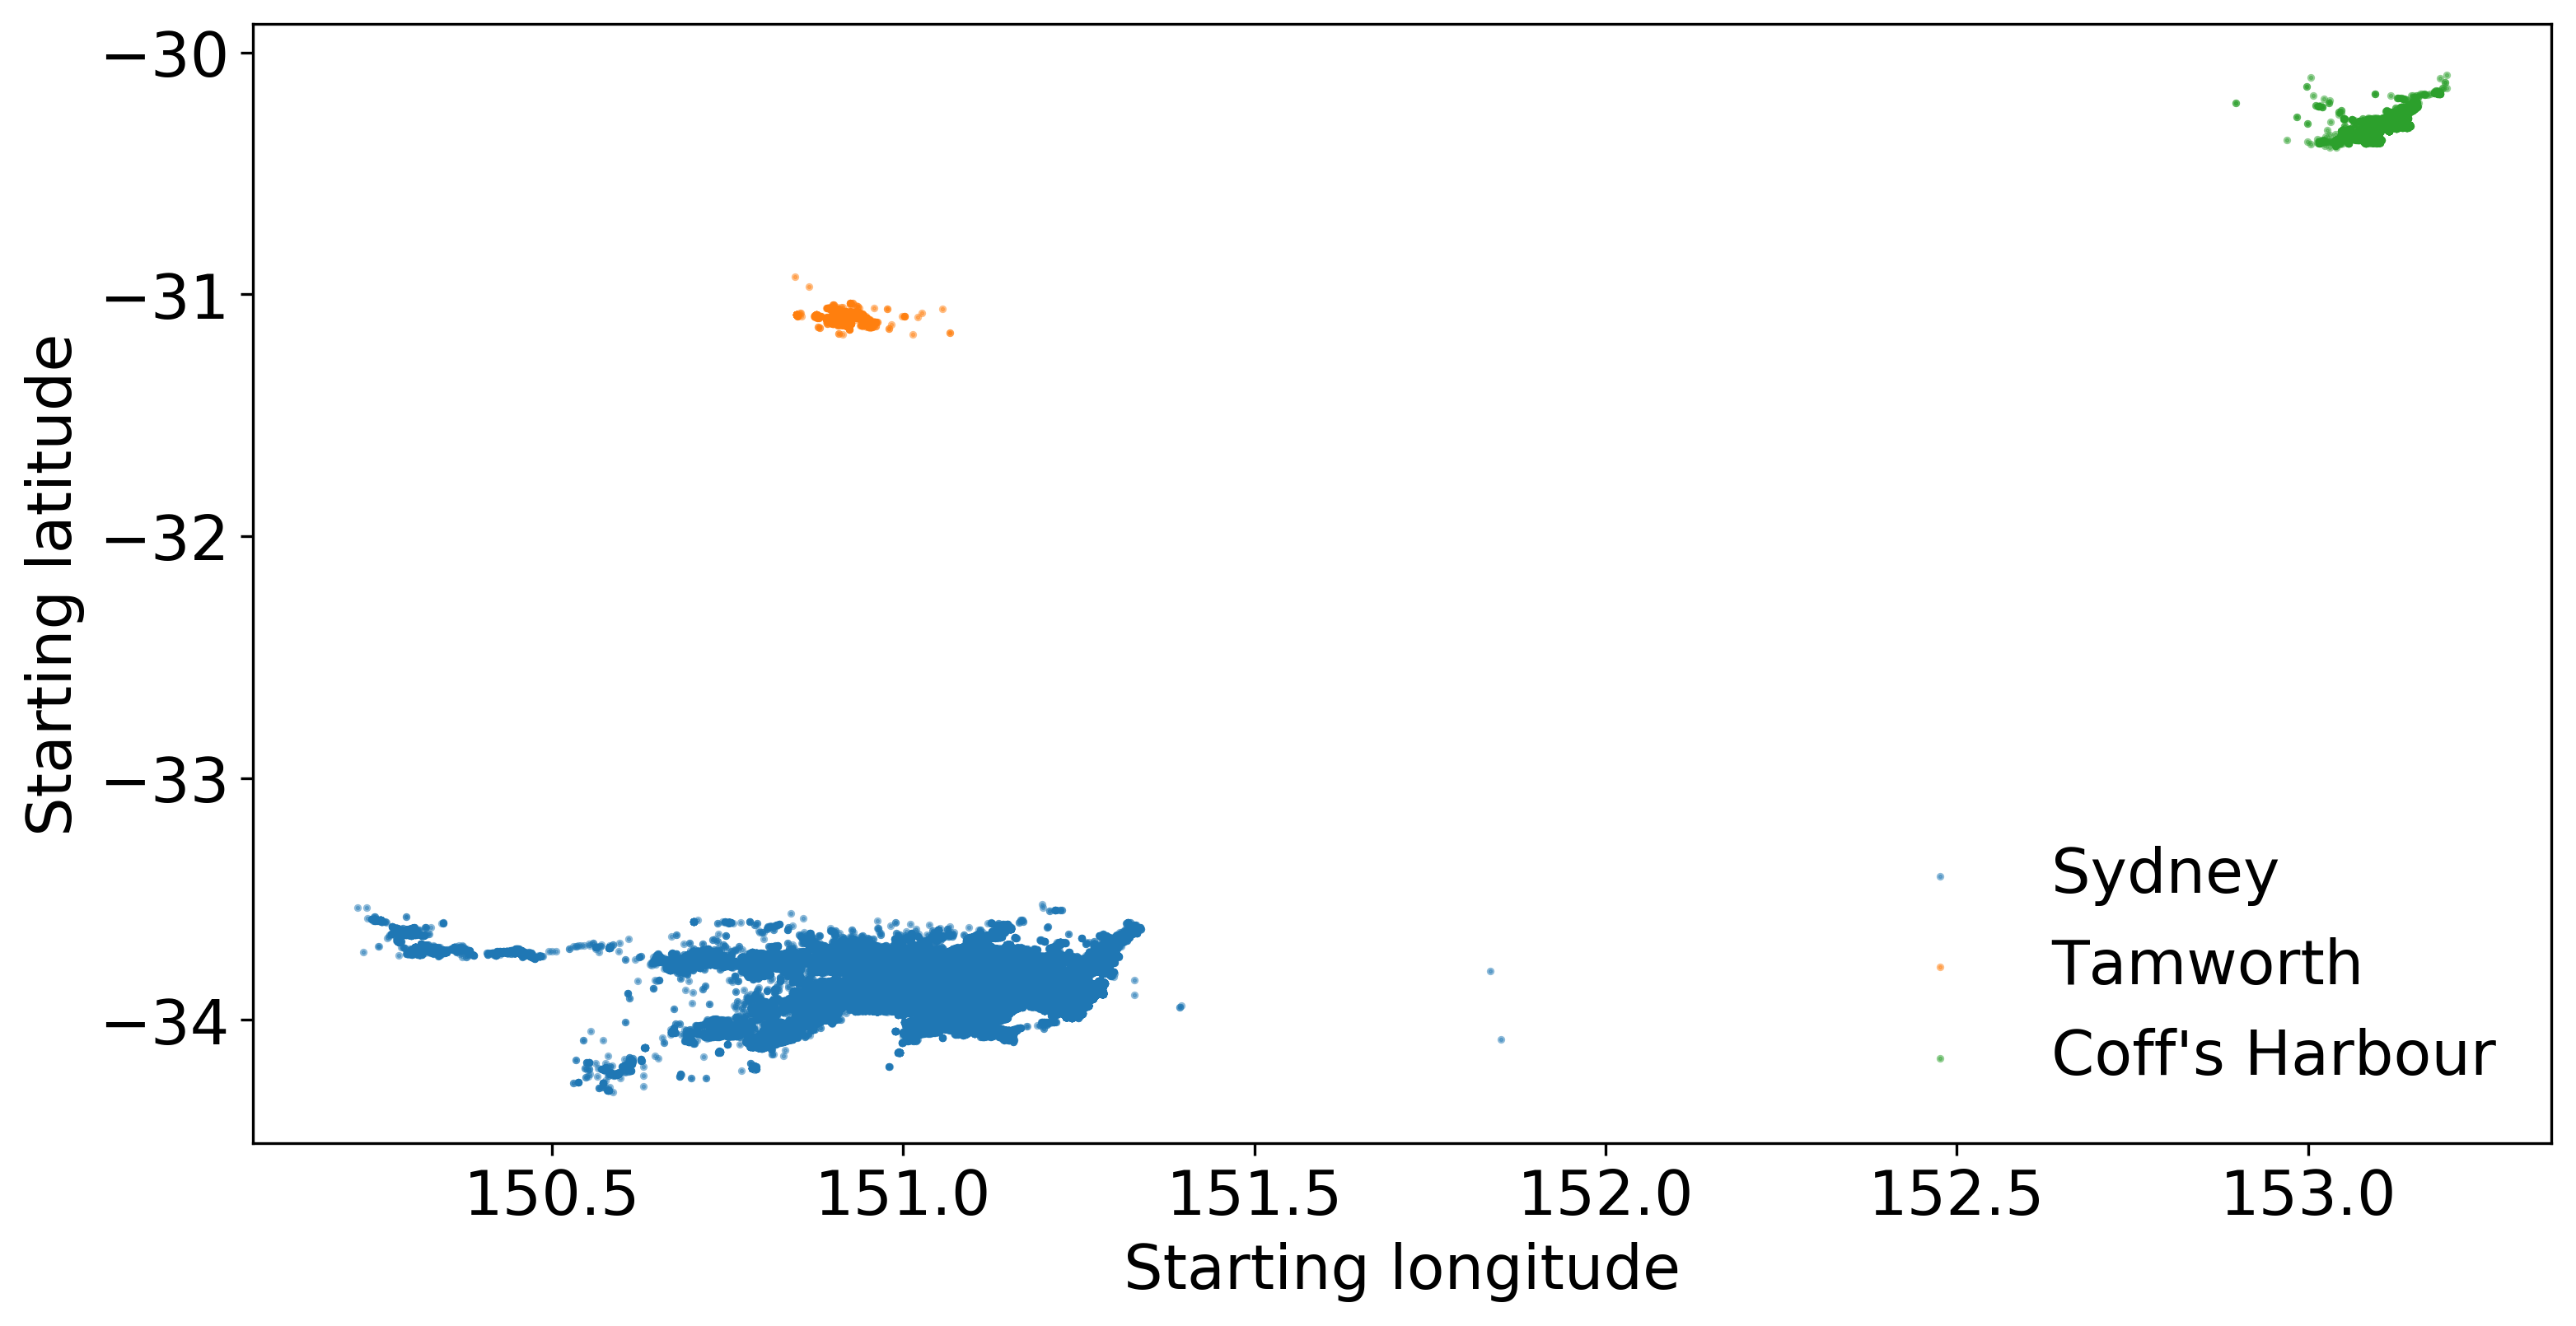

In [101]:
plt.figure(dpi=300)

plt.scatter(data.loc[data['City']=='Sydney',['Long_M_On']],data.loc[data['City']=='Sydney',['Lat_M_On']], label='Sydney', s=1.5, alpha=0.5)
plt.scatter(data.loc[data['City']=='Tamworth',['Long_M_On']],data.loc[data['City']=='Tamworth',['Lat_M_On']], label='Tamworth', s=1.5, alpha=0.5)
plt.scatter(data.loc[data['City']=='Coffs Harbour',['Long_M_On']],data.loc[data['City']=='Coffs Harbour',['Lat_M_On']], label='Coff\'s Harbour', s=1.5, alpha=0.5)

plt.xlabel('Starting longitude')
plt.ylabel('Starting latitude')
plt.legend(framealpha=0)

plt.savefig('city_split.png', transparent=True)

## Train/Test split

In [102]:
train_index, test_index = train_test_split(data.index, test_size=0.3, shuffle=True, random_state=212)

# The data isn't split into training and testing yet, but any preprocessing that uses data to train on
# (e.g. standardising) must be trained/fit on the training indices

## Time

In [103]:
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

data['day_of_week'] = [weekday_names[i] for i in data['M_On_Time'].dt.dayofweek]
data['time_of_day'] = (data['M_On_Time'].dt.hour + data['M_On_Time'].dt.minute/60) /  24    # between 0 and 1

# Labour day public holiday 7th October 2019
data['is_public_holiday'] = ((data['M_On_Time'].dt.date == datetime.strptime('2019-10-07','%Y-%m-%d').date()) & 
                             ((data['M_On_Time'].dt.hour>=6) & 
                              (data['M_On_Time'].dt.hour<22)))

data['is_daylight'] = ((data['M_On_Time'].dt.hour>=6) & (data['M_On_Time'].dt.hour<22))

## Location

### Distance and bearings functions

In [104]:
# Calcluate distances from Sydney city centre
# https://www.movable-type.co.uk/scripts/latlong.html
def dist_lat_long(lat1, long1, lat2, long2):
    R = 6371 # km
    
    lat1 = np.radians(lat1)
    long1 = np.radians(long1)
    lat2 = np.radians(lat2)
    long2 = np.radians(long2)
    
    a = np.sin((lat2-lat1) / 2)**2 / 2 \
          + np.cos(lat1) * np.cos(lat2) * np.sin((long2-long1) / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

In [105]:
def bearing_lat_long(lat1, long1, lat2, long2):

    lat1 = np.radians(lat1)
    long1 = np.radians(long1)
    lat2 = np.radians(lat2)
    long2 = np.radians(long2)
    
    y = np.sin(long2 - long1) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(long2 - long1)

    b = np.arctan2(y, x)

    return np.degrees(b) + 180

In [106]:
def journey_direction(lat_start, long_start, lat_end, long_end):
    bearing = bearing_lat_long(lat_start, long_start, lat_end, long_end)

    return bearing

### Calculate distances and bearings from city centre

In [107]:
city_names = ['Sydney', 'Tamworth', 'Coffs Harbour']

city_centres = np.array([[-33.87097, 151.207285],       # Sydney
                         [-31.09705608, 150.91959076],  # Tamworth
                         [-30.30256865, 153.11363909]]) # Coffs Harbour

data['on_disp_from_city_centre'] = np.nan
data['off_disp_from_city_centre'] = np.nan
data['on_bearing_from_city_centre'] = np.nan
data['off_bearing_from_city_centre'] = np.nan

for city, city_centre in zip(city_names, city_centres):

    data.loc[data['City']==city,['on_disp_from_city_centre']] = dist_lat_long(city_centre[0], 
                                                                              city_centre[1], 
                                                                              data.loc[data['City']==city]['Lat_M_On'], 
                                                                              data.loc[data['City']==city]['Long_M_On'])
    data.loc[data['City']==city,['off_disp_from_city_centre']] = dist_lat_long(city_centre[0], 
                                                                               city_centre[1], 
                                                                               data.loc[data['City']==city]['Lat_M_Off'], 
                                                                               data.loc[data['City']==city]['Long_M_Off'])

    data.loc[data['City']==city,['on_bearing_from_city_centre']] = bearing_lat_long(city_centre[0], 
                                                                                    city_centre[1],
                                                                                    data.loc[data['City']==city]['Lat_M_On'], 
                                                                                    data.loc[data['City']==city]['Long_M_On'])
    data.loc[data['City']==city,['off_bearing_from_city_centre']] = bearing_lat_long(city_centre[0], 
                                                                                     city_centre[1],
                                                                                     data.loc[data['City']==city]['Lat_M_Off'], 
                                                                                     data.loc[data['City']==city]['Long_M_Off'])
                        
        
data['journey_displacement'] = dist_lat_long(data['Lat_M_Off'], data['Long_M_Off'], data['Lat_M_On'], data['Long_M_On'])

data['journey_direction'] = journey_direction(data['Lat_M_Off'], data['Long_M_Off'], data['Lat_M_On'], data['Long_M_On'])

In [108]:
data.head()

,M_On_Time,Lat_M_On,Long_M_On,M_Off_Time,Lat_M_Off,Long_M_Off,City,Dest_Suburb,DelJobDistance,DelJobTime,...,day_of_week,time_of_day,is_public_holiday,is_daylight,on_disp_from_city_centre,off_disp_from_city_centre,on_bearing_from_city_centre,off_bearing_from_city_centre,journey_displacement,journey_direction
0,2019-07-23 06:54:39,-30.353364,153.094583,2019-07-23 07:03:24,-30.322766,153.115583,Coffs Harbour,Coffs Harbour Airport,6000,525,...,Tuesday,0.287500,False,True,4.392688,1.598981,17.937720,355.250034,3.138365,30.634805
1,2019-09-04 16:35:27,-30.310815,153.105125,2019-09-04 16:42:51,-30.287417,153.117083,Coffs Harbour,Coffs Harbour,4150,444,...,Wednesday,0.690972,False,True,1.043286,1.236379,41.710702,191.105350,2.168555,23.807357
3,2019-08-29 20:04:59,-33.888697,151.208008,2019-08-29 20:21:39,-33.871832,151.252742,Sydney,Bellevue Hill,7850,1000,...,Thursday,0.836111,False,True,1.395406,4.197292,358.060250,271.321410,4.337216,65.564299
4,2019-09-19 02:56:22,-33.883459,151.159525,2019-09-19 03:06:43,-33.896778,151.152915,Sydney,Ashfield,2250,627,...,Thursday,0.122222,False,False,4.517098,5.413624,72.503519,60.224556,1.212011,202.393058
5,2019-10-04 10:04:19,-33.894879,151.182564,2019-10-04 10:18:19,-33.875360,151.203414,Sydney,Newtown,3500,845,...,Friday,0.419444,False,True,2.956654,0.496883,40.634601,36.210906,2.461621,41.558493


### Standardise distances and scale directions

Distances scaled to have s.d. = 1 (remaining positive)  
Directions scaled to be between 0 and 1, per advice from Jiahao

In [109]:
def scale_direction(a):
    b = a / 360
    return b

In [110]:
dist_scalers = []

standardise_distance_columns = ['on_disp_from_city_centre', 'off_disp_from_city_centre', 
                                'journey_displacement']
standardise_direction_columns = ['on_bearing_from_city_centre', 'off_bearing_from_city_centre', 
                                 'journey_direction']


for col in standardise_distance_columns:
    scaler = StandardScaler(with_mean=False).fit(data.loc[train_index, [col]]) # train on the training set
    
    data[col] = scaler.transform(data[col].values.reshape(-1,1))
    
    dist_scalers.append(scaler)
    
for col in standardise_direction_columns:
    data[col] = scale_direction(data[col])

## Create dummy variables for categorical features

In [111]:
data = pd.get_dummies(data, drop_first=True, columns=['City', 'day_of_week'])

In [112]:
data.head()

,M_On_Time,Lat_M_On,Long_M_On,M_Off_Time,Lat_M_Off,Long_M_Off,Dest_Suburb,DelJobDistance,DelJobTime,ChargesPrice,...,journey_displacement,journey_direction,City_Sydney,City_Tamworth,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,2019-07-23 06:54:39,-30.353364,153.094583,2019-07-23 07:03:24,-30.322766,153.115583,Coffs Harbour Airport,6000,525,14.1,...,0.770542,0.085097,0,0,0,0,0,0,1,0
1,2019-09-04 16:35:27,-30.310815,153.105125,2019-09-04 16:42:51,-30.287417,153.117083,Coffs Harbour,4150,444,10.9,...,0.532431,0.066132,0,0,0,0,0,0,0,1
3,2019-08-29 20:04:59,-33.888697,151.208008,2019-08-29 20:21:39,-33.871832,151.252742,Bellevue Hill,7850,1000,21.3,...,1.064888,0.182123,1,0,0,0,0,1,0,0
4,2019-09-19 02:56:22,-33.883459,151.159525,2019-09-19 03:06:43,-33.896778,151.152915,Ashfield,2250,627,11.8,...,0.297577,0.562203,1,0,0,0,0,1,0,0
5,2019-10-04 10:04:19,-33.894879,151.182564,2019-10-04 10:18:19,-33.875360,151.203414,Newtown,3500,845,15.1,...,0.604386,0.115440,1,0,0,0,0,0,0,0


# Prediction Models

In [113]:
dummy_cols = [col for col in data.columns if ('City_' in col) or ('day_of_week_' in col)]

features = dummy_cols + ['DelJobDistance', 'DelJobTime',
            'time_of_day', 'is_public_holiday', 
            'on_disp_from_city_centre',
            'on_bearing_from_city_centre',
            'journey_direction'
            ]

target = ['ChargesPrice']

feature_names =['Sydney', 'Tamworth', 
                'Monday','Saturday','Sunday', 'Thursday','Tuesday', 'Wednesday', 
                'Distance', 'Time', 'Time of day', 
                'Public holiday', 
                'Starting geodesic distance from city centre', 
                'Starting direction from city centre', 'Journey direction'
               ]


In [114]:
x_train = data.loc[train_index, features].copy()
y_train = data.loc[train_index, target].copy()

x_test = data.loc[test_index, features].copy()
y_test = data.loc[test_index, target].copy()

In [115]:
# smaller random sample for quicker tuning

x_train_sample = x_train.sample(10000, random_state=1234)
y_train_sample = y_train.sample(10000, random_state=1234)

# Evaluate predictions

In [116]:
def evaluate(y_true, y_pred):    
    errors = y_true - y_pred
    
    acc_10 = np.mean( (np.abs( errors/y_true ) <= 0.1).astype(int) )
    
    acc_20 = np.mean( (np.abs( errors/y_true ) <= 0.2).astype(int) )
    
    RMSE = np.sqrt( np.mean ( (errors)**2 ) )
    
    MAD = np.mean( np.abs( errors ) )
    
    MAPE = np.mean( np.abs( errors/y_true ) * 100 )
    
    print('Accuracy within 10%: {:.3f}'.format(acc_10))
    print('Accuracy within 20%: {:.3f}'.format(acc_20))
    print('RMSE:                {:.3f}'.format(RMSE))
    print('MAD:                 {:.3f}'.format(MAD))
    print('MAPE:                {:.3f}%'.format(MAPE))

    return acc_10, acc_20, RMSE, MAD, MAPE

## Extreme Gradient Boosting XGBoost

### Find best parameters

In [22]:
%%time

xgboost = xgb.XGBRegressor()

tuning_parameters = {
    'learning_rate': [0.02, 0.05, 0.08, 0.1],
    'n_estimators' : [1200, 1500, 1800, 2000],
    'max_depth' : [3, 4, 5, 6],
    'subsample' : [0.5, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(xgboost, tuning_parameters, n_iter = 16, cv = 5, return_train_score=False, n_jobs=4,
                              random_state = 20)

# No need to run
#gb_search.fit(x_train_sample, y_train_sample)
#xbst = gb_search.best_estimator_

#print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Wall time: 0 ns


### Fit model to training data

In [24]:
%%time
params = {'subsample': 0.8, 'n_estimators': 1200, 'max_depth': 4, 'learning_rate': 0.02}
xbst = xgb.XGBRegressor(objective='reg:squarederror',**params)

Wall time: 0 ns


In [ ]:
%%time
xbst.fit(x_train, y_train)

In [ ]:
y_pred_is = xbst.predict(x_train)

print('In-sample measures:')
acc_10, acc_20, RMSE, MAD, MAPE = evaluate(np.asarray(y_train).reshape(-1), np.asarray(y_pred_is))

In [ ]:
y_pred = xbst.predict(x_test)

print('Validation measures:')
acc_10, acc_20, RMSE, MAD, MAPE = evaluate(np.asarray(y_test).reshape(-1), np.asarray(y_pred))

### Plot feature importance

In [23]:
def bar(labels, importance, name):
    df = pd.DataFrame()
    df['labels'] = labels
    df['importance'] = importance

    df = df.sort_values('importance')
    plt.figure(dpi=300)

    plt.barh(df['labels'], df['importance'])
    plt.xlabel('Relative importance')
    
    plt.savefig(name)

In [ ]:
bar(feature_names, (xbst.feature_importances_), 'xgbst_importance_bar_15.png')

# Evaluate Final Model on Test Set

### Load and pre-processs test data

In [156]:
test_data = pd.read_excel('A2B_Validation_Dataset_v2.xlsx')

In [151]:
#test_data.drop(columns=['Unnamed: 0', 'BookingID'], inplace=True)

test_data['M_On_Time'] = pd.to_datetime(test_data['M_On_Time'])
test_data['M_Off_Time'] = pd.to_datetime(test_data['M_Off_Time'])

In [138]:
test_data.head()

,M_On_Time,Lat_M_On,Long_M_On,M_Off_Time,Lat_M_Off,Long_M_Off,City,Dest_Suburb,DelJobDistance,DelJobTime
0,2019-07-31 09:46:29,-33.888076,151.250466,2019-07-31 10:02:57,-33.866181,151.208214,Sydney,Woollahra,6500,988
1,2019-09-25 10:10:11,-30.308583,153.097583,2019-09-25 10:19:53,-30.295804,153.112208,Tamworth,Coffs Harbour,2600,581
2,2019-10-23 11:16:57,-33.884341,151.249567,2019-10-23 11:24:32,-33.891694,151.252091,Sydney,Bellevue Hill,1550,456
3,2019-09-08 18:54:37,-33.863193,151.213925,2019-09-08 19:04:48,-33.883792,151.230299,Sydney,Paddington,3900,612
4,2019-08-25 09:57:07,-33.849820,151.217599,2019-08-25 10:00:27,-33.846256,151.212690,Sydney,Kirribilli,700,201


In [139]:
test_data['City'].where((test_data['City']=='Sydney') | (test_data['Long_M_On']<=152), 'Coffs Harbour', inplace=True)

test_data['day_of_week'] = [weekday_names[i] for i in test_data['M_On_Time'].dt.dayofweek]
test_data['time_of_day'] = (test_data['M_On_Time'].dt.hour + test_data['M_On_Time'].dt.minute/60) /  24    # between 0 and 1

# Labour day public holiday 7th October 2019
test_data['is_public_holiday'] = ((test_data['M_On_Time'].dt.date == datetime.strptime('2019-10-07','%Y-%m-%d').date()) & 
                                 ((test_data['M_On_Time'].dt.hour>=6) & 
                                  (test_data['M_On_Time'].dt.hour<22)))

test_data['is_daylight'] = ((test_data['M_On_Time'].dt.hour>=6) & (test_data['M_On_Time'].dt.hour<22))

In [140]:
test_data['on_disp_from_city_centre'] = np.nan
test_data['off_disp_from_city_centre'] = np.nan
test_data['on_bearing_from_city_centre'] = np.nan
test_data['off_bearing_from_city_centre'] = np.nan

for city, city_centre in zip(city_names, city_centres):

    test_data.loc[test_data['City']==city,['on_disp_from_city_centre']] = dist_lat_long(city_centre[0], 
                                                                                        city_centre[1], 
                                                                                        test_data.loc[test_data['City']==city]['Lat_M_On'], 
                                                                                        test_data.loc[test_data['City']==city]['Long_M_On'])
    test_data.loc[test_data['City']==city,['off_disp_from_city_centre']] = dist_lat_long(city_centre[0], 
                                                                                        city_centre[1], 
                                                                                        test_data.loc[test_data['City']==city]['Lat_M_Off'], 
                                                                                        test_data.loc[test_data['City']==city]['Long_M_Off'])

    test_data.loc[test_data['City']==city,['on_bearing_from_city_centre']] = bearing_lat_long(city_centre[0], 
                                                                                            city_centre[1],
                                                                                            test_data.loc[test_data['City']==city]['Lat_M_On'], 
                                                                                            test_data.loc[test_data['City']==city]['Long_M_On'])
    test_data.loc[test_data['City']==city,['off_bearing_from_city_centre']] = bearing_lat_long(city_centre[0], 
                                                                                                   city_centre[1],
                                                                                                   test_data.loc[test_data['City']==city]['Lat_M_Off'], 
                                                                                                   test_data.loc[test_data['City']==city]['Long_M_Off'])
                        
        
test_data['journey_displacement'] = dist_lat_long(test_data['Lat_M_Off'], test_data['Long_M_Off'], 
                                                  test_data['Lat_M_On'], test_data['Long_M_On'])

test_data['journey_direction'] = journey_direction(test_data['Lat_M_Off'], test_data['Long_M_Off'], 
                                                   test_data['Lat_M_On'], test_data['Long_M_On'])

In [141]:
# Standardise

for col, scaler in zip(standardise_distance_columns, dist_scalers):
    #scaler = StandardScaler(with_mean=False).fit(data.loc[train_index, [col]]) # train on the training set
    
    test_data[col] = scaler.transform(test_data[col].values.reshape(-1,1))
    

for col in standardise_direction_columns:
    test_data[col] = scale_direction(test_data[col])

In [142]:
test_data = pd.get_dummies(test_data, drop_first=True, columns=['City', 'day_of_week'])

In [143]:
x_final_test = test_data[features].copy()

## Train on entire training set

In [117]:
x_all = data[features].copy()
y_all = data[target].copy()

In [118]:
xbst_final = xgb.XGBRegressor(objective='reg:squarederror',**params)
xbst_final.fit(x_all, y_all)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.02, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
             validate_parameters=False, verbosity=None)

In [126]:
# Save to binary
xbst_final.save_model('Group2XGBoost-FinalTrainedModel.bin')

# Final Test Predictions

In [144]:
# Load saved final model
final_model = xgb.XGBRegressor() 
final_model.load_model('Group2XGBoost-FinalTrainedModel.bin')

In [160]:
y_test_pred = final_model.predict(x_final_test)

# Save final predictions
predictions = test_data[['Unnamed: 0', 'BookingID']].copy()
predictions['ChargesPrice'] = y_test_pred
predictions.to_csv('QBUS3600GroupAssignmentGroup2S12020-Predictions.csv')